In [2]:
# https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
import keras

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras import Sequential

from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Precision, Recall, Accuracy
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [4]:
nltk.download('stopwords')
nltk.download('wordnet')
STOPWORDS = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\janna\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\janna\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
tweets = pd.read_csv("./twitter_training.csv")
tweets.head()

,id,name,label,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


### Cleaning and remove unusable data from DataFrame

In [6]:
tweets.drop(["id", "name"], axis=1, inplace=True)

In [7]:
tweets.head()

,label,text
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


In [8]:
tweets["label"] = np.where(tweets["label"] == "Positive", 1, 0) # twitter returned 4 as positive

### Data Analysis

In [9]:
tweets["label"].unique()

array([1, 0])

In [10]:
tweets["label"].value_counts()

label
0    53850
1    20832
Name: count, dtype: int64

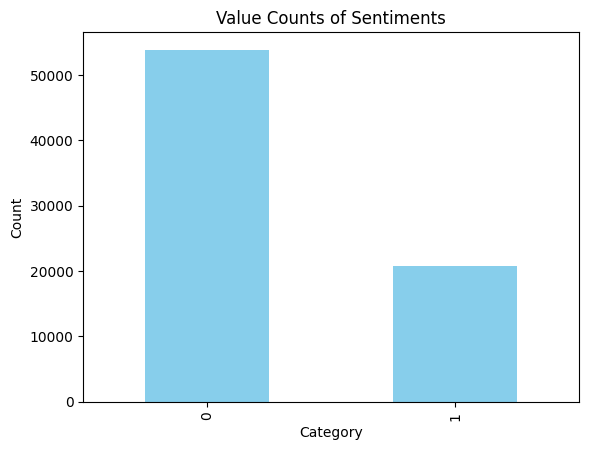

In [11]:
counts = tweets['label'].value_counts()

counts.plot(kind='bar', color='skyblue')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Value Counts of Sentiments')
plt.show()

### Pre processing

In [12]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   74682 non-null  int32 
 1   text    73996 non-null  object
dtypes: int32(1), object(1)
memory usage: 875.3+ KB


In [13]:
# dataframe para treinamento do embedding do tensorflow
df_tensorflow = tweets.copy()

In [14]:
df_tensorflow["text"] = df_tensorflow["text"].astype(str)

In [15]:
lemmatizer = WordNetLemmatizer()

def pre_process(text):
    text = re.sub(r'http\S+', '', text) # remove links from text
    text = re.sub(r'@\S+', '', text) # remove mentions from text
    text = re.sub(r'[^A-Za-z]+', ' ', text) # Keep only letters (remove numbers and special characters)
    text = [lemmatizer.lemmatize(word) for word in text.split() if word not in STOPWORDS] # remove stop words and lemmatize the words
    text = " ".join(text)

    return text.lower().strip()

In [16]:
df_tensorflow["text"] = df_tensorflow["text"].apply(pre_process)

In [17]:
df_tensorflow.head()

,label,text
0,1,im getting borderland murder
1,1,i coming border i kill
2,1,im getting borderland kill
3,1,im coming borderland murder
4,1,im getting borderland murder


### Padronize Data

In [18]:
max_features = 10000

word_tokenizer = Tokenizer(
    oov_token="<OOV>",
    lower=True,
    num_words=max_features,
)

In [19]:
word_tokenizer.fit_on_texts(df_tensorflow["text"])

In [20]:
word_tokenizer.word_index

{'<OOV>': 1,
 'i': 2,
 'game': 3,
 'com': 4,
 'the': 5,
 'like': 6,
 'get': 7,
 'pic': 8,
 'twitter': 9,
 'one': 10,
 'play': 11,
 'good': 12,
 'time': 13,
 'love': 14,
 'this': 15,
 'new': 16,
 'really': 17,
 'it': 18,
 'johnson': 19,
 'unk': 20,
 'people': 21,
 'shit': 22,
 'u': 23,
 'see': 24,
 'player': 25,
 'best': 26,
 'go': 27,
 'still': 28,
 'facebook': 29,
 'year': 30,
 'a': 31,
 'got': 32,
 'day': 33,
 'great': 34,
 'make': 35,
 'even': 36,
 'playing': 37,
 'amazon': 38,
 'you': 39,
 'fucking': 40,
 'fuck': 41,
 'xbox': 42,
 'k': 43,
 'dead': 44,
 'google': 45,
 'rhandlerr': 46,
 'please': 47,
 'look': 48,
 'microsoft': 49,
 'back': 50,
 'know': 51,
 'tv': 52,
 'much': 53,
 'red': 54,
 'fifa': 55,
 'going': 56,
 'would': 57,
 'first': 58,
 'and': 59,
 'home': 60,
 'so': 61,
 'my': 62,
 'want': 63,
 'guy': 64,
 'today': 65,
 'video': 66,
 'v': 67,
 'x': 68,
 'fun': 69,
 'gta': 70,
 'twitch': 71,
 'call': 72,
 'pubg': 73,
 'also': 74,
 'say': 75,
 'fix': 76,
 'verizon': 77,
 'e

In [21]:
len(word_tokenizer.word_index)

27911

In [22]:
X_sequences = word_tokenizer.texts_to_sequences(df_tensorflow["text"])

In [23]:
X_padded = pad_sequences(X_sequences, padding="post", truncating="post", maxlen=100) # preenche os arrays com 0 na esquerda para todos ficarem com mesmo tamanho

### Split data

In [24]:
X_train, y_train = X_padded, df_tensorflow["label"]

In [25]:
df_val = pd.read_csv("twitter_validation.csv")
df_val.drop(["id", "name"], axis=1, inplace=True)
df_val["label"] = np.where(df_val["label"] == "Positive", 1, 0) # twitter returned 4 as positive

df_val["text"] = df_val["text"].apply(pre_process)

X_val_sequences = word_tokenizer.texts_to_sequences(df_val["text"])
X_val_padded = pad_sequences(X_val_sequences, padding="post", truncating="post", maxlen=100)
y_val = df_val["label"]

### Build LSTM Model

In [26]:
max_features = len(word_tokenizer.word_index) + 1
output_dim = 64

In [27]:
model = Sequential([
    Embedding(input_dim=max_features, output_dim=output_dim),
    LSTM(64, return_sequences=True),
    tf.keras.layers.GlobalAveragePooling1D(),
    Dropout(0.5),
    Dense(24, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [28]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [29]:
model.fit(X_train, y_train, epochs=20)

Epoch 1/20


2334/2334 [==============================] - 50s 20ms/step - loss: 0.5434 - accuracy: 0.7209
Epoch 2/20
2334/2334 [==============================] - 48s 21ms/step - loss: 0.4454 - accuracy: 0.7740
Epoch 3/20
2334/2334 [==============================] - 48s 20ms/step - loss: 0.3422 - accuracy: 0.8452
Epoch 4/20
2334/2334 [==============================] - 48s 20ms/step - loss: 0.2556 - accuracy: 0.8957
Epoch 5/20
2334/2334 [==============================] - 48s 20ms/step - loss: 0.1920 - accuracy: 0.9236
Epoch 6/20
2334/2334 [==============================] - 48s 20ms/step - loss: 0.1470 - accuracy: 0.9412
Epoch 7/20
2334/2334 [==============================] - 48s 20ms/step - loss: 0.1207 - accuracy: 0.9518
Epoch 8/20
2334/2334 [==============================] - 49s 21ms/step - loss: 0.1023 - accuracy: 0.9598
Epoch 9/20
2334/2334 [==============================] - 47s 20ms/step - loss: 0.0914 - accuracy: 0.9640
Epoch 10/20
2334/2334 [==============================] - 47s 2

In [30]:
loss, acc = model.evaluate(X_val_padded, y_val)

32/32 [==============================] - 1s 6ms/step - loss: 0.1094 - accuracy: 0.9840


In [31]:
print(f"Model Loss: {loss}\nModel Accuracy: {acc}")

Model Loss: 0.10940482467412949
Model Accuracy: 0.984000027179718


### Build Simple Model

In [32]:
model = Sequential([
    Embedding(input_dim=max_features, output_dim=output_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation="relu"),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [33]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [34]:
model.fit(X_train, y_train, epochs=20)

Epoch 1/20
2334/2334 [==============================] - 19s 8ms/step - loss: 0.4769 - accuracy: 0.7742
Epoch 2/20
2334/2334 [==============================] - 18s 8ms/step - loss: 0.3375 - accuracy: 0.8508
Epoch 3/20
2334/2334 [==============================] - 18s 8ms/step - loss: 0.2893 - accuracy: 0.8747
Epoch 4/20
2334/2334 [==============================] - 18s 8ms/step - loss: 0.2631 - accuracy: 0.8880
Epoch 5/20
2334/2334 [==============================] - 18s 8ms/step - loss: 0.2496 - accuracy: 0.8928
Epoch 6/20
2334/2334 [==============================] - 18s 8ms/step - loss: 0.2379 - accuracy: 0.8989
Epoch 7/20
2334/2334 [==============================] - 18s 8ms/step - loss: 0.2309 - accuracy: 0.9012
Epoch 8/20
2334/2334 [==============================] - 18s 8ms/step - loss: 0.2181 - accuracy: 0.9058
Epoch 9/20
2334/2334 [==============================] - 18s 8ms/step - loss: 0.2043 - accuracy: 0.9119
Epoch 10/20
2334/2334 [==============================] - 18s 8ms/step - l

In [35]:
loss, acc = model.evaluate(X_val_padded, y_val)

32/32 [==============================] - 0s 1ms/step - loss: 0.1414 - accuracy: 0.9630


In [36]:
print(f"Model Loss: {loss}\nModel Accuracy: {acc}")

Model Loss: 0.1413571536540985
Model Accuracy: 0.9629999995231628


## LSTM Model V2

In [41]:
model = Sequential([
    Embedding(input_dim=max_features, output_dim=output_dim),
    LSTM(64, return_sequences=True),
    Dropout(0.5),
    Dense(24, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [42]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [43]:
model.fit(X_train, y_train, epochs=20)

Epoch 1/20
2334/2334 [==============================] - 52s 22ms/step - loss: 0.5044 - accuracy: 0.7734
Epoch 2/20
2334/2334 [==============================] - 50s 21ms/step - loss: 0.4629 - accuracy: 0.7929
Epoch 3/20
2334/2334 [==============================] - 50s 21ms/step - loss: 0.4287 - accuracy: 0.8093
Epoch 4/20
2334/2334 [==============================] - 50s 21ms/step - loss: 0.3748 - accuracy: 0.8476
Epoch 5/20
2334/2334 [==============================] - 50s 21ms/step - loss: 0.3015 - accuracy: 0.8719
Epoch 6/20
2334/2334 [==============================] - 50s 21ms/step - loss: 0.2721 - accuracy: 0.8819
Epoch 7/20
2334/2334 [==============================] - 51s 22ms/step - loss: 0.2207 - accuracy: 0.9075
Epoch 8/20
2334/2334 [==============================] - 50s 21ms/step - loss: 0.1797 - accuracy: 0.9251
Epoch 9/20
2334/2334 [==============================] - 50s 21ms/step - loss: 0.1498 - accuracy: 0.9373
Epoch 10/20
2334/2334 [==============================] - 50s 21m

In [44]:
loss, acc = model.evaluate(X_val_padded, y_val)

32/32 [==============================] - 1s 6ms/step - loss: 0.1547 - accuracy: 0.9736


In [45]:
print(f"Model Loss: {loss}\nModel Accuracy: {acc}")

Model Loss: 0.15472809970378876
Model Accuracy: 0.9735599160194397


## LSTM Model V3

In [ ]:
model = Sequential([
    Embedding(input_dim=max_features, output_dim=output_dim),
    LSTM(64, return_sequences=True),
    Dropout(0.5),
    Dense(24, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [48]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [49]:
model.fit(X_train, y_train, epochs=20)

Epoch 1/20
2334/2334 [==============================] - 60s 24ms/step - loss: 0.5083 - accuracy: 0.7710
Epoch 2/20
2334/2334 [==============================] - 57s 24ms/step - loss: 0.4862 - accuracy: 0.7962
Epoch 3/20
2334/2334 [==============================] - 56s 24ms/step - loss: 0.4083 - accuracy: 0.8323
Epoch 4/20
2334/2334 [==============================] - 55s 24ms/step - loss: 0.2781 - accuracy: 0.8869
Epoch 5/20
2334/2334 [==============================] - 55s 24ms/step - loss: 0.2105 - accuracy: 0.9136
Epoch 6/20
2334/2334 [==============================] - 55s 24ms/step - loss: 0.1690 - accuracy: 0.9299
Epoch 7/20
2334/2334 [==============================] - 55s 24ms/step - loss: 0.1388 - accuracy: 0.9424
Epoch 8/20
2334/2334 [==============================] - 55s 24ms/step - loss: 0.1164 - accuracy: 0.9523
Epoch 9/20
2334/2334 [==============================] - 55s 24ms/step - loss: 0.0983 - accuracy: 0.9596
Epoch 10/20
2334/2334 [==============================] - 55s 24m

In [50]:
loss, acc = model.evaluate(X_val_padded, y_val)

32/32 [==============================] - 1s 6ms/step - loss: 0.1698 - accuracy: 0.9718


In [51]:
print(f"Model Loss: {loss}\nModel Accuracy: {acc}")

Model Loss: 0.16983526945114136
Model Accuracy: 0.9718299508094788


## LSTM Model V5

In [52]:
model = Sequential([
    Embedding(input_dim=max_features, output_dim=output_dim),
    tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.5),
    tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [53]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [54]:
model.fit(X_train, y_train, epochs=20)

Epoch 1/20
2334/2334 [==============================] - 139s 57ms/step - loss: 0.4862 - accuracy: 0.7778
Epoch 2/20
2334/2334 [==============================] - 132s 56ms/step - loss: 0.4286 - accuracy: 0.8105
Epoch 3/20
2334/2334 [==============================] - 129s 55ms/step - loss: 0.3069 - accuracy: 0.8751
Epoch 4/20
2334/2334 [==============================] - 130s 56ms/step - loss: 0.2308 - accuracy: 0.9099
Epoch 5/20
2334/2334 [==============================] - 131s 56ms/step - loss: 0.1862 - accuracy: 0.9272
Epoch 6/20
2334/2334 [==============================] - 129s 55ms/step - loss: 0.1516 - accuracy: 0.9391
Epoch 7/20
2334/2334 [==============================] - 128s 55ms/step - loss: 0.1284 - accuracy: 0.9477
Epoch 8/20
2334/2334 [==============================] - 130s 56ms/step - loss: 0.1085 - accuracy: 0.9565
Epoch 9/20
2334/2334 [==============================] - 128s 55ms/step - loss: 0.0957 - accuracy: 0.9613
Epoch 10/20
2334/2334 [==============================] 

In [55]:
loss, acc = model.evaluate(X_val_padded, y_val)

32/32 [==============================] - 2s 17ms/step - loss: 0.1551 - accuracy: 0.9741


In [56]:
print(f"Model Loss: {loss}\nModel Accuracy: {acc}")

Model Loss: 0.1551460474729538
Model Accuracy: 0.9741100072860718
